In [121]:
import glob
import os
import random

from ficus import FigureManager
import ijson
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from numerize import numerize

In [3]:
random.seed(42)

In [129]:
@mpl.ticker.FuncFormatter
def numerize_fmtr(x, pos):
    return numerize.numerize(x)

## Results: Download Datarate Figure

In [333]:
files = sorted(glob.glob('../results/chap1/SAM*.curl.txt'))
samples = set([os.path.basename(f).split('.')[0] for f in files])

In [334]:
def get_diffs(df):
    return pd.DataFrame({'d_t': df['elapsed_s'][1:].values - df['elapsed_s'][:-1].values,
                         'd_bytes': df['bytes_read'][1:].values - df['bytes_read'][:-1].values,
                         't': df['elapsed_s'][1:]})

In [335]:
stream_df = []
for accession in samples:
    print(f'Reading {accession}...')
    left_fn = f'../results/chap1/{accession}.1.curl.txt'
    right_fn = f'../results/chap1/{accession}.2.curl.txt'
    ldf = get_diffs(pd.read_table(left_fn, delim_whitespace=True, names=['elapsed_s', 'bytes_read']))
    rdf = get_diffs(pd.read_table(right_fn, delim_whitespace=True, names=['elapsed_s', 'bytes_read']))
    
    bins = list(range(0, int(max(ldf.t.max(), rdf.t.max())), 5))
    
    ldf = ldf.groupby(pd.cut(ldf.t, labels=bins[1:], bins=bins)).mean()
    ldf['bytes/s'] = ldf.d_bytes / ldf.d_t
    rdf = rdf.groupby(pd.cut(rdf.t, labels=bins[1:], bins=bins)).mean()
    rdf['bytes/s'] = rdf.d_bytes / rdf.d_t
    
    df = pd.DataFrame({'t': ldf.index,
                       'bytes/s': ldf['bytes/s'] + rdf['bytes/s'],
                       'accession': accession})
    df['MiB/s'] = df['bytes/s'] / 1048576

    stream_df.append(df.copy())
stream_df = pd.concat(stream_df).reset_index(drop=True)

Reading SAMEA3894957...
Reading SAMN03493070...
Reading SAMEA4791499...
Reading SAMEA6498954...
Reading SAMN10236109...
Reading SAMEA104703328...
Reading SAMEA2747216...
Reading SAMEA3176945...
Reading SAMN10537738...
Reading SAMN09378356...
Reading SAMEA103927134...
Reading SAMN08038114...
Reading SAMEA4064425...
Reading SAMN10520155...
Reading SAMN05991912...
Reading SAMN04126864...
Reading SAMEA4774291...
Reading SAMN04349088...
Reading SAMN10236070...
Reading SAMN04576178...
Reading SAMN04088456...
Reading SAMN03002991...
Reading SAMN09758735...


In [336]:
stream_df.head()

,t,bytes/s,accession,MiB/s
0,5,1.888283e+04,SAMEA3894957,0.018008
1,10,1.264188e+06,SAMEA3894957,1.205623
2,15,1.383822e+06,SAMEA3894957,1.319715
3,20,1.718212e+06,SAMEA3894957,1.638615
4,25,1.904960e+06,SAMEA3894957,1.816712


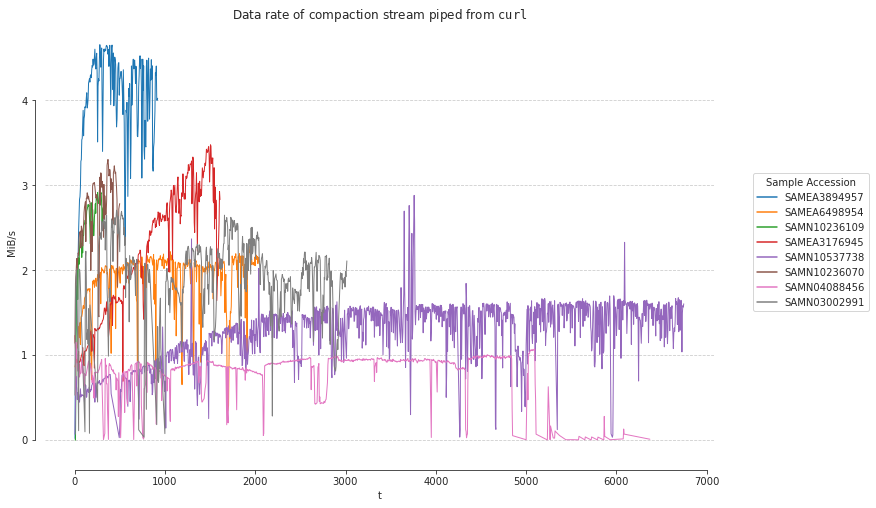

In [349]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, figsize=(12,8)) as (fig, ax):
    
    random.seed(42)
    subsampled = random.sample(list(stream_df.accession.unique()), 8)
    
    
    sns.lineplot(data=stream_df[stream_df['accession'].isin(subsampled)], 
                 x='t', y='MiB/s', hue='accession', lw=1, legend=True, ax=ax)
    ax.set_title('Data rate of compaction stream piped from $\mathtt{curl}$')
    ax.legend(bbox_to_anchor=(1.05, .5), loc='center left', title='Sample Accession')
    sns.despine(fig=fig, offset=10, trim=True)
    ax.yaxis.grid(ls='--')

## Results: Decision Nodes Figure

In [389]:
files = sorted(glob.glob('../results/chap1/cdbg-stream/*/goetia.cdbg.stats.json'))
samples = set([f.split('/')[4] for f in files])

In [390]:
def normalize_metrics(data):
    df['t_norm'] = df['t'] / df['t'].max()

    cdbg_cols =['n_full', 'n_tips', 'n_islands', 'n_trivial', 'n_circular']
    for col in cdbg_cols:
        data[col + '_p'] = data[col] / data['n_unodes']
    data['dnode_p'] = data['n_dnodes'] / (data['n_unodes'] + data['n_dnodes'])
    data['kmer_p'] = data['n_unique_kmers'] / data['n_unique_kmers'].max()
    prop_cols = [col + '_p' for col in cdbg_cols] + [ 'kmer_p']
    
    return data, prop_cols

In [391]:
metrics_df = []
for f in files:
    print(f)
    try:
        df = pd.read_json(f)
        df, prop_cols = normalize_metrics(df)
    except ValueError:
        pass
    else:
        df['t_norm'] = df['t'] / df['t'].max()
        metrics_df.append(df)
metrics_df = pd.concat(metrics_df).reset_index(drop=True)
metrics_df['sample_name'] = metrics_df.sample_name.str.rpartition('.')[0]

../results/chap1/cdbg-stream/SAMEA103927134/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA104703328/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA2747216/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA3176945/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA3894957/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA4064425/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA4774291/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA4791499/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA6498954/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMN03002991/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMN03493070/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMN04088456/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMN04126864/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMN04349088/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMN04576178/goetia.cdbg.stats.json
../results/chap1/cdbg

In [392]:
metrics_df.head()

,t,seq_t,rt_elapsed_interval,rt_elapsed_total,sample_name,n_full,n_tips,n_islands,n_trivial,n_circular,...,n_unique_kmers,estimated_fp,t_norm,n_full_p,n_tips_p,n_islands_p,n_trivial_p,n_circular_p,dnode_p,kmer_p
0,5000135,52633,13.163505,13.163891,SAMEA103927134,12478,13035,18413,2689,0,...,2681613,0,0.013191,0.267642,0.279589,0.394942,0.057677,0.000000,0.305259,0.044804
1,10000270,105266,2.931621,16.095590,SAMEA103927134,25583,26472,29874,5272,0,...,4795154,0,0.026383,0.293322,0.303515,0.342521,0.060446,0.000000,0.323797,0.080116
2,15000310,157898,2.693477,18.789150,SAMEA103927134,39357,40320,38539,8072,1,...,6673528,0,0.039574,0.311576,0.319199,0.305100,0.063903,0.000008,0.336241,0.111500
3,20000350,210530,2.891793,21.681015,SAMEA103927134,54170,54556,44781,11046,2,...,8348020,0,0.052765,0.329127,0.331472,0.272081,0.067113,0.000012,0.346137,0.139477
4,25000485,263163,2.721536,24.402633,SAMEA103927134,69029,67612,49965,14215,2,...,9888165,0,0.065956,0.343671,0.336616,0.248758,0.070771,0.000010,0.353252,0.165209


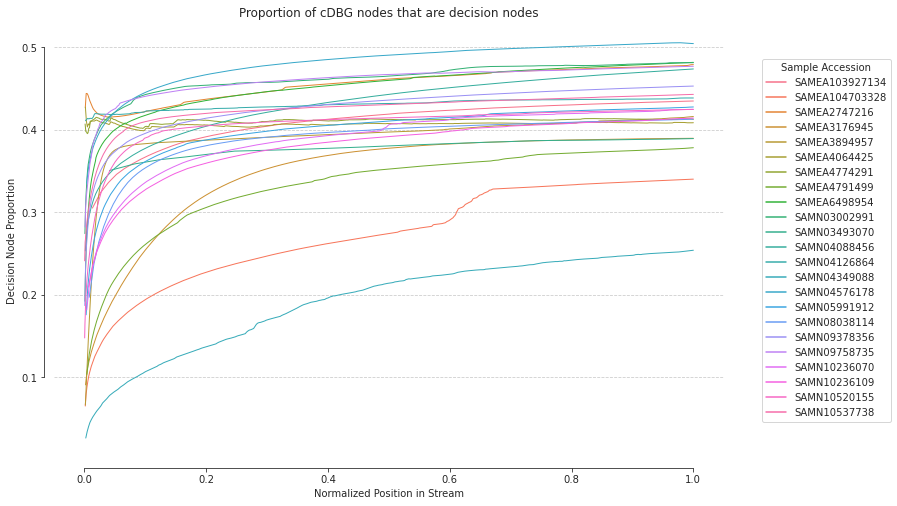

In [393]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, figsize=(12,8)) as (fig, ax):
    
    sns.lineplot(data=metrics_df, x='t_norm', y='dnode_p', hue='sample_name', lw=1, ax=ax)
    ax.set_ylabel('Decision Node Proportion')
    ax.set_xlabel('Normalized Position in Stream')
    ax.legend(bbox_to_anchor=(1.05, .5), loc='center left', title='Sample Accession')
    ax.set_title('Proportion of cDBG nodes that are decision nodes')
    
    sns.despine(fig=fig, offset=10, trim=True)
    ax.yaxis.grid(ls='--')

In [ ]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, figsize=(12,len(files) * 2), tight_layout=True, nrows=len(files)//2, ncols=2) as (fig, axs):
    
    from matplotlib.lines import Line2D
    
    for i, sample_name in enumerate(comps_df.sample_name.unique()):
        ax = axs[i // 2, i % 2]
    
        #mdf = comps_df.query('sample_name == "SAMN09758735"')
        mdf = comps_df.query(f'sample_name == "{sample_name}"')
        #df = mdf.reset_index().melt(value_vars=['min', 'max', 'n_components'], id_vars=['sample_name', 't'])
        g = sns.lineplot(data=mdf, x='t_norm', y='n_components', lw=2, color=sns.color_palette()[0], ax=ax)
        sax = g.axes.twinx()
        sns.lineplot(data=mdf, x='t_norm', y='max', lw=2, color=sns.color_palette()[1], ax=sax)
        ax.set_ylabel('Components')
        ax.set_xlabel('Normalized Position in Stream')
        ax.set_title(sample_name)
        sax.set_ylabel('Max Component Size')

        g.legend(handles=[Line2D([], [], marker='_', color=sns.color_palette()[0], label='Components'), 
                          Line2D([], [], marker='_', color=sns.color_palette()[1], label='Max Component Size')],
                loc='lower right')
        sns.despine(ax=ax, offset=10, trim=True, right=False)
        sns.despine(ax=sax, offset=10, trim=True, right=False)
        ax.yaxis.grid(ls='--')

In [394]:
metrics_df

,t,seq_t,rt_elapsed_interval,rt_elapsed_total,sample_name,n_full,n_tips,n_islands,n_trivial,n_circular,...,n_unique_kmers,estimated_fp,t_norm,n_full_p,n_tips_p,n_islands_p,n_trivial_p,n_circular_p,dnode_p,kmer_p
0,5000135,52633,13.163505,13.163891,SAMEA103927134,12478,13035,18413,2689,0,...,2681613,0,0.013191,0.267642,0.279589,0.394942,0.057677,0.000000e+00,0.305259,0.044804
1,10000270,105266,2.931621,16.095590,SAMEA103927134,25583,26472,29874,5272,0,...,4795154,0,0.026383,0.293322,0.303515,0.342521,0.060446,0.000000e+00,0.323797,0.080116
2,15000310,157898,2.693477,18.789150,SAMEA103927134,39357,40320,38539,8072,1,...,6673528,0,0.039574,0.311576,0.319199,0.305100,0.063903,7.916653e-06,0.336241,0.111500
3,20000350,210530,2.891793,21.681015,SAMEA103927134,54170,54556,44781,11046,2,...,8348020,0,0.052765,0.329127,0.331472,0.272081,0.067113,1.215163e-05,0.346137,0.139477
4,25000485,263163,2.721536,24.402633,SAMEA103927134,69029,67612,49965,14215,2,...,9888165,0,0.065956,0.343671,0.336616,0.248758,0.070771,9.957283e-06,0.353252,0.165209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16213,11920341620,98515220,2.137545,6739.288705,SAMN10537738,56464404,23184669,629456,11333556,18,...,1512157621,0,0.998332,0.616340,0.253073,0.006871,0.123712,1.964799e-07,0.443062,0.998999
16214,11925341703,98556543,2.114395,6741.403166,SAMN10537738,56476940,23192200,629641,11337935,18,...,1512512224,0,0.998751,0.616311,0.253088,0.006871,0.123727,1.964271e-07,0.443070,0.999233
16215,11930341907,98597867,2.088531,6743.491762,SAMN10537738,56489225,23199304,629799,11342375,18,...,1512847019,0,0.999170,0.616284,0.253099,0.006871,0.123743,1.963757e-07,0.443078,0.999454
16216,11935341990,98639190,2.108276,6745.600104,SAMN10537738,56501960,23206956,629992,11347065,18,...,1513212370,0,0.999589,0.616253,0.253113,0.006871,0.123760,1.963216e-07,0.443086,0.999695


## Results: Component Distribution Figure

In [355]:
files = sorted(glob.glob('../results/chap1/cdbg-build/*/goetia.cdbg.components.json'))

In [356]:
def parse_components_metrics(fp):
    backend = ijson.get_backend('yajl2')
    metrics = []
    #sizes = []
    for row in backend.items(fp, 'item'):
        metrics.append({k: row[k] for k in set(row.keys()) - set(('sizes',))})
        #sizes.append(sorted(row['sizes']))
    metrics_df = pd.DataFrame(metrics)
    #sizes_df = pd.DataFrame(sizes, index=metrics_df.index)
    return metrics_df

In [357]:
files

['../results/chap1/cdbg-build/SAMEA103927134/goetia.cdbg.components.json',
 '../results/chap1/cdbg-build/SAMEA2747216/goetia.cdbg.components.json',
 '../results/chap1/cdbg-build/SAMEA4791499/goetia.cdbg.components.json',
 '../results/chap1/cdbg-build/SAMEA6498954/goetia.cdbg.components.json',
 '../results/chap1/cdbg-build/SAMN03002991/goetia.cdbg.components.json',
 '../results/chap1/cdbg-build/SAMN03493070/goetia.cdbg.components.json',
 '../results/chap1/cdbg-build/SAMN04349088/goetia.cdbg.components.json',
 '../results/chap1/cdbg-build/SAMN04576178/goetia.cdbg.components.json',
 '../results/chap1/cdbg-build/SAMN05991912/goetia.cdbg.components.json',
 '../results/chap1/cdbg-build/SAMN08038114/goetia.cdbg.components.json',
 '../results/chap1/cdbg-build/SAMN09378356/goetia.cdbg.components.json',
 '../results/chap1/cdbg-build/SAMN09758735/goetia.cdbg.components.json',
 '../results/chap1/cdbg-build/SAMN10236070/goetia.cdbg.components.json',
 '../results/chap1/cdbg-build/SAMN10236109/goetia

In [373]:
comps_df = []
for f in files:
    print(f)
    try:
        with open(f) as fp:
            mdf = parse_components_metrics(fp)
            mdf['t_norm'] = mdf['t'] / mdf['t'].max()
            comps_df.append(mdf)
    except ijson.IncompleteJSONError:
        print(f'JSON error in {f}')
        pass
comps_df = pd.concat(comps_df).reset_index(drop=True)
#comps_df['sample_name'] = metrics_df.sample_name.str.rpartition('.')[0]

../results/chap1/cdbg-build/SAMEA103927134/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMEA2747216/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMEA4791499/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMEA6498954/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN03002991/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN03493070/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN04349088/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN04576178/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN05991912/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN08038114/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN09378356/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN09758735/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN10236070/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN10236109/goetia.cdbg.components.json


In [374]:
comps_df['log_n_components'] = np.log(comps_df['n_components'])

In [375]:
comps_df

,sample_name,t,min,max,n_components,t_norm,log_n_components
0,SAMEA103927134,25005805,1,190889,58610,0.066667,10.978661
1,SAMEA103927134,50011135,1,399496,80423,0.133333,11.295055
2,SAMEA103927134,75016655,1,623399,91303,0.200000,11.421939
3,SAMEA103927134,100021700,1,843697,96804,0.266665,11.480444
4,SAMEA103927134,125027030,1,1074223,99444,0.333331,11.507350
...,...,...,...,...,...,...,...
847,SAMN10236109,505034999,1,4248257,234642,0.723495,12.365816
848,SAMN10236109,548038137,1,4579344,239545,0.785099,12.386497
849,SAMN10236109,594041522,1,4949490,247367,0.851002,12.418628
850,SAMN10236109,644045118,1,5340729,256749,0.922636,12.455854


In [376]:
#mdf.reset_index().melt(value_vars=['min', 'max', 'n_components'], id_vars=['sample_name', 't'])

In [377]:
len(files)

14

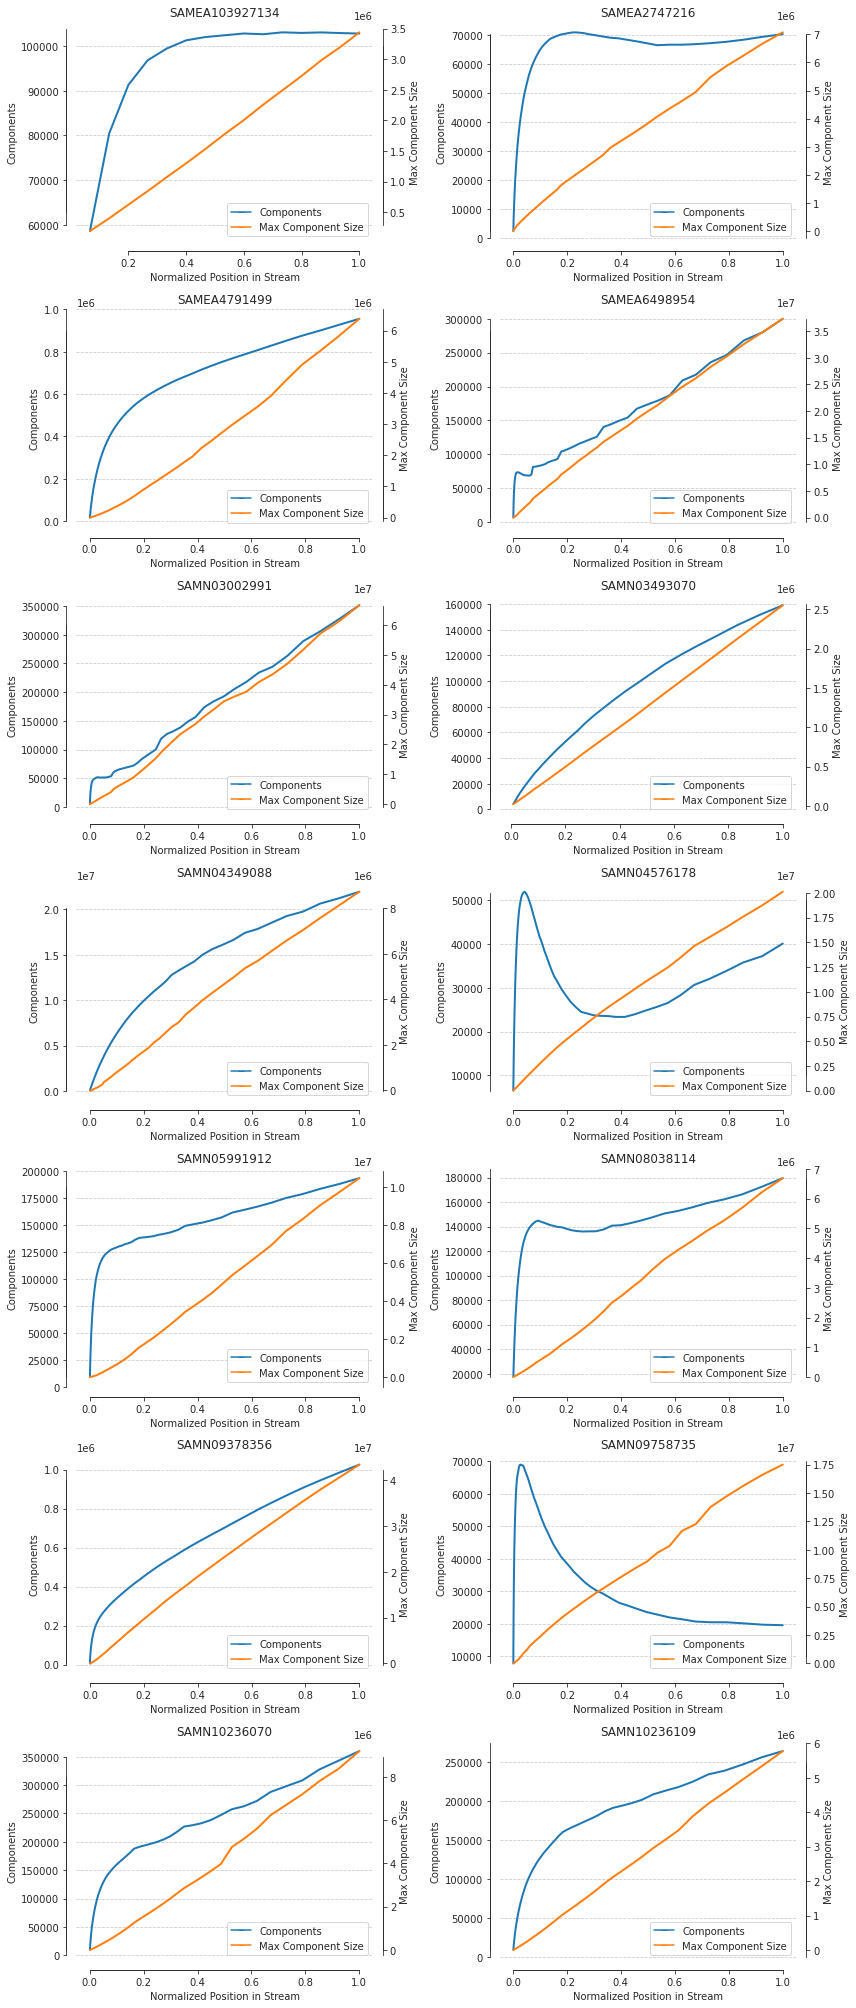

In [388]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, figsize=(12,len(files) * 2), tight_layout=True, nrows=len(files)//2, ncols=2) as (fig, axs):
    
    from matplotlib.lines import Line2D
    
    for i, sample_name in enumerate(comps_df.sample_name.unique()):
        ax = axs[i // 2, i % 2]
    
        #mdf = comps_df.query('sample_name == "SAMN09758735"')
        mdf = comps_df.query(f'sample_name == "{sample_name}"')
        #df = mdf.reset_index().melt(value_vars=['min', 'max', 'n_components'], id_vars=['sample_name', 't'])
        g = sns.lineplot(data=mdf, x='t_norm', y='n_components', lw=2, color=sns.color_palette()[0], ax=ax)
        sax = g.axes.twinx()
        sns.lineplot(data=mdf, x='t_norm', y='max', lw=2, color=sns.color_palette()[1], ax=sax)
        ax.set_ylabel('Components')
        ax.set_xlabel('Normalized Position in Stream')
        ax.set_title(sample_name)
        sax.set_ylabel('Max Component Size')

        g.legend(handles=[Line2D([], [], marker='_', color=sns.color_palette()[0], label='Components'), 
                          Line2D([], [], marker='_', color=sns.color_palette()[1], label='Max Component Size')],
                loc='lower right')
        sns.despine(ax=ax, offset=10, trim=True, right=False)
        sns.despine(ax=sax, offset=10, trim=True, right=False)
        ax.yaxis.grid(ls='--')


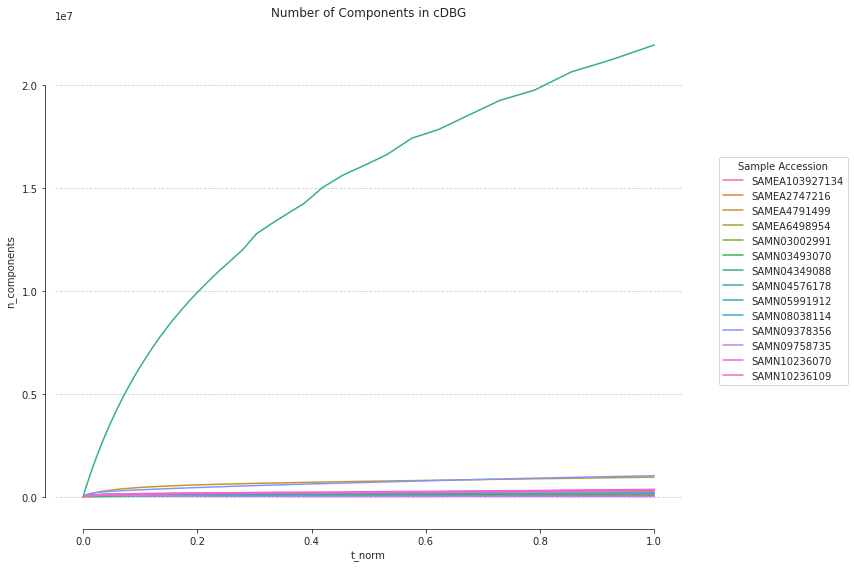

In [386]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, tight_layout=True, figsize=(12,8)) as (fig, ax):
    
    sns.lineplot(data=comps_df, x='t_norm', y='n_components',  hue='sample_name', lw=1.5, ax=ax)
    ax.legend(bbox_to_anchor=(1.05, .5), loc='center left', title='Sample Accession')
    ax.set_title('Number of Components in cDBG')
    
    sns.despine(fig=fig, offset=10, trim=True)
    ax.yaxis.grid(ls='--')

In [ ]:
.query('sample_name == "SAMN08038114"')

## Results: Unitig Fragmentation Figure

In [313]:
files = sorted(glob.glob('../results/chap1/cdbg-build/*/goetia.cdbg.unitigs.bp.json'))

In [316]:
pd.read_json(files[0])

,t,sample_name,"[31,50)","[50,100)","[100,200)","[200,400)","[400,800)","[800,Inf)"
0,5001465,SAMEA103927134,98057,414499,2024876,158970,5281,0
1,10002550,SAMEA103927134,197467,825246,3357944,361072,12420,0
2,15003350,SAMEA103927134,304758,1253280,4452988,573324,26400,0
3,20004720,SAMEA103927134,418113,1705592,5322092,778416,37273,0
4,25005805,SAMEA103927134,527277,2137351,6082013,986164,47257,0
...,...,...,...,...,...,...,...,...
77,355079315,SAMEA103927134,8243212,25765173,17124309,4324671,367352,0
78,360080305,SAMEA103927134,8352985,26048872,17185180,4318833,367202,0
79,365081200,SAMEA103927134,8462396,26343284,17243298,4317525,363450,0
80,370082285,SAMEA103927134,8577409,26642128,17322848,4311054,365392,0


In [320]:
frag_df = []
for f in files:
    print(f)
    try:
        fdf = pd.read_json(f)
        fdf['t_norm'] = fdf['t'] / fdf['t'].max()
        frag_df.append(fdf)
    except ValueError:
        pass
frag_df = pd.concat(frag_df).reset_index(drop=True)

../results/chap1/cdbg-build/SAMEA103927134/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMEA2747216/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMEA4791499/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMEA6498954/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN03002991/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN03493070/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN04349088/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN04576178/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN05991912/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN08038114/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN09378356/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN09758735/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN10236070/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN10236109/goetia.cdbg.unitigs.bp.json


In [325]:
frag_df = frag_df.melt(id_vars=['sample_name', 't', 't_norm'], var_name='Unitig Length Bin')

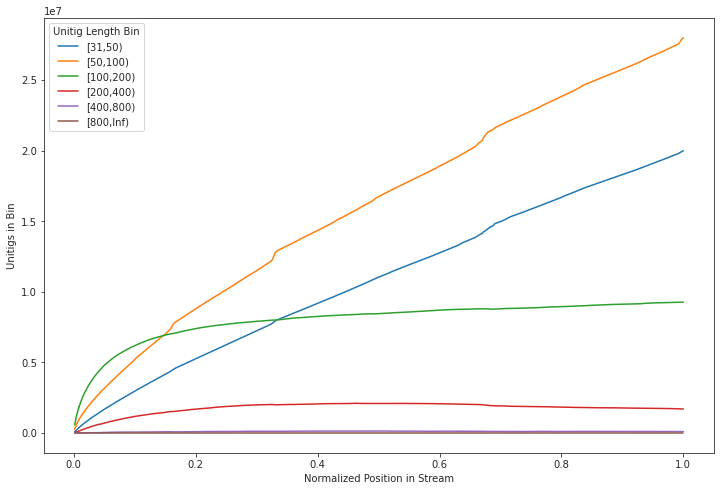

In [331]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, figsize=(12,8)) as (fig, ax):
    
    df = frag_df.query('sample_name == "SAMEA2747216"')
    sns.lineplot(data=df, x='t_norm', y='value',  hue='Unitig Length Bin', ax=ax)
    ax.set_xlabel('Normalized Position in Stream')
    ax.set_ylabel('Unitigs in Bin')

In [332]:
len(files)

14

## Results: Datarate Comparisons

In [91]:
def calc_rates(df):
    return pd.DataFrame({'kmers/s': (df['t'].values[1:] - df['t'].values[:-1]) / df['rt_elapsed_interval'].values[1:],
                         'seqs/s': (df['seq_t'].values[1:] - df['seq_t'].values[:-1]) / df['rt_elapsed_interval'].values[1:],
                         't': df['t'].values[1:],
                         'sample_name': df['sample_name'].values[1:],
                         't_norm': df['t_norm'].values[1:],
                         'rt_elapsed_total': df['rt_elapsed_total'][1:]})

In [93]:
def read_metrics_files(files):
    metrics_df = []
    for f in files:
        print(f)
        try:
            df = pd.read_json(f)
        except ValueError as e:
            print(f'Error reading {f}: {e}')
            pass
        else:
            df['t_norm'] = df['t'] / df['t'].max()
            metrics_df.append(calc_rates(df))
    metrics_df = pd.concat(metrics_df).reset_index(drop=True)
    return metrics_df

In [94]:
cdbg_metrics_files =  sorted(glob.glob('../results/chap1/cdbg-build/*/goetia.cdbg.stats.json'))
dbg_baseline_files = sorted(glob.glob('../results/chap1/dbg-stream-baseline/*/metrics.json'))
hash_baseline_files = sorted(glob.glob('../results/chap1/hash-stream-baseline/*/metrics.json'))

In [96]:
cdbg_metrics = read_metrics_files(cdbg_metrics_files)
dbg_metrics = read_metrics_files(dbg_baseline_files)
hash_metrics = read_metrics_files(hash_baseline_files)

../results/chap1/cdbg-build/SAMEA103927134/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMEA2747216/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMEA4791499/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMEA6498954/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN03002991/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN03493070/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN04349088/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN04576178/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN05991912/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN08038114/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN09378356/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN09758735/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN10236070/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN10236109/goetia.cdbg.stats.json
../results/chap1/dbg-stream-baseline/SAMEA103927134/metrics.json
../results/chap1/dbg-stream-baseline/

In [100]:
hash_metrics['operation'] = 'hash'
dbg_metrics['operation'] = 'dbg'
cdbg_metrics['operation'] = 'cdbg'

In [101]:
rates_df = pd.concat((hash_metrics, dbg_metrics, cdbg_metrics))

In [104]:
rates_df.head()

,kmers/s,seqs/s,t,sample_name,t_norm,rt_elapsed_total,operation
0,6.084570e+07,640481.029462,2000225,SAMEA103927134,0.005277,0.327774,hash
1,5.560891e+07,585356.947196,3000385,SAMEA103927134,0.007916,0.345805,hash
2,5.326101e+07,560642.233565,4000545,SAMEA103927134,0.010554,0.364626,hash
3,5.553823e+07,584612.918943,5000705,SAMEA103927134,0.013193,0.382679,hash
4,5.598629e+07,589329.326414,6000770,SAMEA103927134,0.015831,0.400585,hash


In [105]:
rates_df.groupby(['sample_name', 'operation']).mean().reset_index()

,sample_name,operation,kmers/s,seqs/s,t,t_norm,rt_elapsed_total
0,SAMEA103927134,cdbg,2.474837e+06,2.605092e+04,1.900419e+08,0.501365,106.865749
1,SAMEA103927134,dbg,8.081181e+06,8.506507e+04,1.910203e+08,0.503946,25.291056
2,SAMEA103927134,hash,5.511239e+07,5.801304e+05,1.910203e+08,0.503946,3.760407
3,SAMEA2747216,cdbg,6.066860e+06,8.544873e+04,1.685617e+09,0.500436,380.228709
4,SAMEA2747216,dbg,1.369843e+07,1.929357e+05,1.685617e+09,0.500436,123.388232
5,SAMEA2747216,hash,4.883298e+07,6.877885e+05,1.685617e+09,0.500436,34.783834
6,SAMEA4791499,cdbg,2.288007e+06,5.084459e+04,6.230368e+08,0.501101,384.717163
7,SAMEA4791499,dbg,6.566236e+06,1.459164e+05,6.230368e+08,0.501101,101.360832
8,SAMEA4791499,hash,3.839249e+07,8.531665e+05,6.230368e+08,0.501101,16.597236
9,SAMEA6498954,cdbg,2.760594e+06,2.380043e+04,2.759820e+09,0.500250,1528.664185


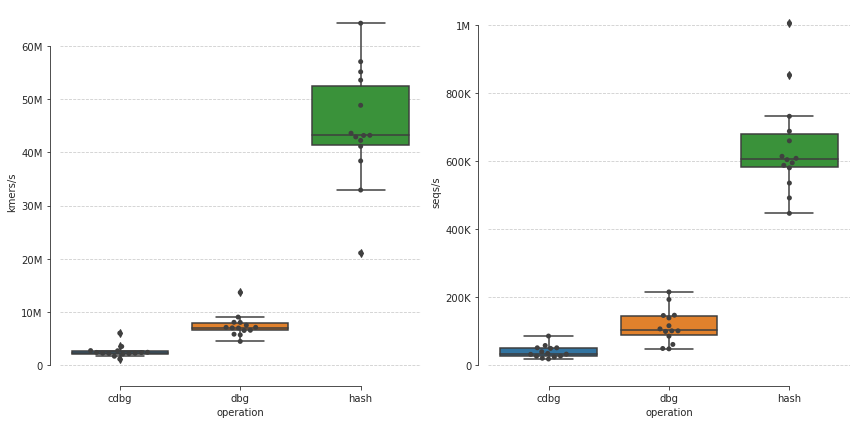

In [131]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, tight_layout=True, ncols=2, figsize=(12,6)) as (fig, axs):
    
    mean_rates = data=rates_df.groupby(['sample_name', 'operation']).mean().reset_index()
    sns.boxplot(x='operation', y='kmers/s', data=mean_rates, ax=axs[0])
    sns.swarmplot(x='operation', y='kmers/s', data=mean_rates, color=".25", ax=axs[0])
    
    sns.boxplot(x='operation', y='seqs/s', data=mean_rates, ax=axs[1])
    sns.swarmplot(x='operation', y='seqs/s', data=mean_rates, color=".25", ax=axs[1])
    
    #ax.legend(bbox_to_anchor=(1.05, .5), loc='center left', title='Sample Accession')
    #ax.set_title('Number of Components in cDBG')
    
    sns.despine(ax=axs[0], offset=10, trim=True)
    axs[0].yaxis.grid(ls='--')
    axs[0].yaxis.set_major_formatter(numerize_fmtr)
    
    sns.despine(ax=axs[1], offset=10, trim=True)
    axs[1].yaxis.grid(ls='--')
    axs[1].yaxis.set_major_formatter(numerize_fmtr)